In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from monk_helpers import CV
from sklearn.metrics import mean_squared_error



In [2]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  df = pd.read_csv(path, sep=" ", names=['NaN','y','x1','x2','x3','x4','x5','x6','garbage'])
  y, df = df['y'], df.drop(columns=['NaN','garbage','y'])
  
  # One-hot encoding categorical variables
  df = pd.get_dummies(df, columns=['x1','x2','x3','x4','x5','x6']).astype('int')

  return (df, y)

In [3]:
# Datasets Path
TR_PATH_1 = "./monks/datasets/monks-1.train"
TS_PATH_1 = "./monks/datasets/monks-1.test"
# Datasets Path
TR_PATH_2 = "./monks/datasets/monks-2.train"
TS_PATH_2 = "./monks/datasets/monks-2.test"
# Datasets Path
TR_PATH_3 = "./monks/datasets/monks-3.train"
TS_PATH_3 = "./monks/datasets/monks-3.test"

In [4]:


cv_strategy = CV

In [5]:
# Function extracting each grid from dictionary of grids
def list_grids(grids_dict):
    return [grids_dict[item] for item in grids_dict]

In [6]:
# Function that prints the classification report
def print_report_score(test_label, test_pred):
    mse = mean_squared_error(test_label, test_pred)
    print("MSE: ", mse)
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [7]:
GRID_GAUSSIAN_NB = { 'var_smoothing': np.logspace(0,-9, num=100) }
GRID_BERNULLI_NB = { 'alpha': np.linspace(0,1, num=100), "force_alpha":[True] }
GRID_KNN = { 
            'n_neighbors' : range(1,25), 
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
            'metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 
            'weights' : ['distance', 'uniform'] 
            }
GRID_MNB = {  }

GRID_SVM = {
  "linear_rbf_sigmoid": {
   "kernel": ['linear', 'rbf','sigmoid'],
   "C":[0.01,10,100],
   "gamma" : ['scale', 'auto']
  },
  "poly": {
    "kernel": ['poly'],
    "C":[0.01,10,100],
    "degree": [2,3,5],
    "gamma" : ['scale', 'auto']
  }
    } 
GRID_LGREG = { 
    "lbfgs_newton-cg_newton-cholesky_sag": {
    "penalty": ['l2', None],
    "fit_intercept":[True,False],
    "class_weight":[{0:0.6,1:0.4},"balanced"],
    "solver":['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    },
    "liblinear":{
    "penalty": ['l1', 'l2'],
    "fit_intercept":[True,False],
    "class_weight":[{0:0.6,1:0.4},"balanced"],
    "solver":['liblinear'],
    },
    "saga":{
    "penalty": ['l1', 'l2','elasticnet',None],
    "l1_ratio":[0.5,0.6,0.7,0.3],
    "fit_intercept":[True,False],
    "class_weight":[{0:0.6,1:0.4},"balanced"],
    "solver":['saga'],
    }
 }

GRID_DT = {
        'criterion': ['gini', 'entropy','log_loss'],
        'max_depth': [5,10,None],
        'max_features': ['sqrt', 'log2', None],
        'min_samples_split': [2,4,8,16],
        'min_samples_leaf': [1,2,4,8]
        }
        
#Ensemble methods:
GRID_RF = {
    'max_depth': [5, 15, None],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64, 128],
    "bootstrap": [True, False],
    "criterion": ["entropy", "gini", "log_loss"]
    }

params_map = {
    'gaussian_nb': GRID_GAUSSIAN_NB,
    'bernulli_nb': GRID_BERNULLI_NB,
    'multinomial_nb': GRID_MNB,
    'knn': GRID_KNN,
    "svm": GRID_SVM,
    "logistic_regression":GRID_LGREG,
    "decision_tree":GRID_DT,
    "random_forest":GRID_RF
    }

In [8]:
def execute_gridesearch(X, y, model, model_name):
  params = params_map[model_name]
  if((model_name == "logistic_regression") or (model_name == "svm")):
    params = list_grids(params)
  grid = GridSearchCV(model, params,scoring="accuracy",refit=True, cv=cv_strategy, n_jobs=-1,verbose=10).fit(X, y)
  results = pd.DataFrame(grid.cv_results_)

  #TODO ADD Train_error

  print("Mean validation accuracy: ", results["mean_test_score"][grid.best_index_])

  print("Mean validation accuracy: ", results["mean_test_score"][grid.best_index_])
  print("Mean std validation accuracy: ", results["std_test_score"][grid.best_index_])
  return grid



In [9]:
# Function that prints the confusion matrix
def print_confusion_matrix(test_label, pred_label):
    cm = confusion_matrix(test_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    disp.plot()
    plt.show()

In [10]:

def do_sklearn_GridSearchCV(X,y,X_test,y_test,model,model_name,i):
    print("Model Used: " + model_name + " On monk: ",i)
    grid = execute_gridesearch(X, y, model, model_name)
    print("Model used: " + model_name + ", best parameters: " + str(grid.best_params_) )
    y_pred = grid.best_estimator_.predict(X_test)
    print("accuracy on test set {:.3f}".format(accuracy_score(y_test,y_pred)))
    print_report_score(y_test,y_pred)
    print_confusion_matrix(y_test,y_pred)
    print("------------------------------------------------------------------------------------------------------")


In [11]:
def grid_search_model(model,model_name):
    for i in range(0,3):
        if i == 0:
            X_train, y_train = read_ds(TR_PATH_1)
            X_test, y_test = read_ds(TS_PATH_1)
        elif i == 1:
            X_train, y_train = read_ds(TR_PATH_2)
            X_test, y_test = read_ds(TS_PATH_2)
        elif i == 2:
            X_train, y_train = read_ds(TR_PATH_3)
            X_test, y_test = read_ds(TS_PATH_3)
        grid_svm = do_sklearn_GridSearchCV(X_train,y_train,X_test,y_test,model,model_name,i+1)

# Logistic Regression

Model Used: logistic_regressionOn monk:  1
Fitting 5 folds for each of 104 candidates, totalling 520 fits


Mean validation accuracy:  0.7586666666666668
Mean std validation accuracy:  0.09007651068829088
Model used: logistic_regression, best parameters: {'class_weight': 'balanced', 'fit_intercept': True, 'penalty': None, 'solver': 'lbfgs'}
accuracy on test set 0.711
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       216
           1       0.74      0.66      0.69       216

    accuracy                           0.71       432
   macro avg       0.71      0.71      0.71       432
weighted avg       0.71      0.71      0.71       432



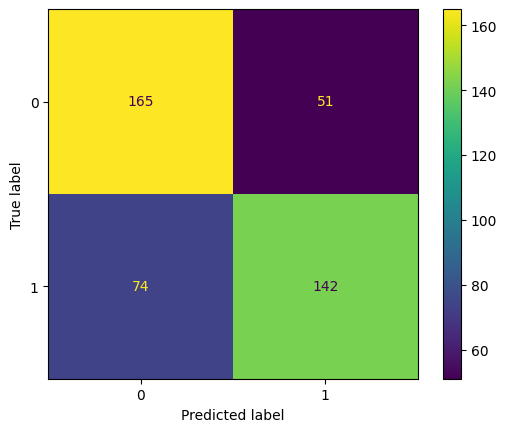

------------------------------------------------------------------------------------------------------
Model Used: logistic_regressionOn monk:  2
Fitting 5 folds for each of 104 candidates, totalling 520 fits
Mean validation accuracy:  0.6219251336898395
Mean std validation accuracy:  0.08400318915875485
Model used: logistic_regression, best parameters: {'class_weight': {0: 0.6, 1: 0.4}, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy on test set 0.671
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       290
           1       0.00      0.00      0.00       142

    accuracy                           0.67       432
   macro avg       0.34      0.50      0.40       432
weighted avg       0.45      0.67      0.54       432



c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

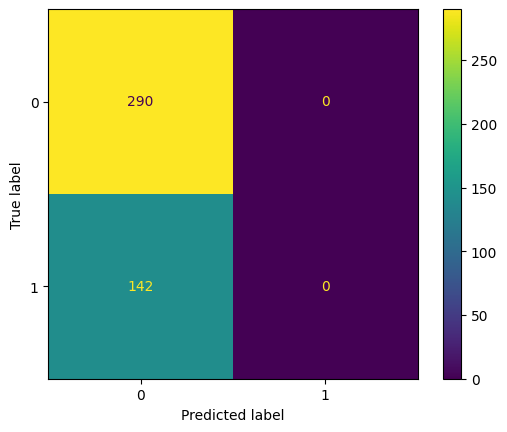

------------------------------------------------------------------------------------------------------
Model Used: logistic_regressionOn monk:  3
Fitting 5 folds for each of 104 candidates, totalling 520 fits
Mean validation accuracy:  0.9339999999999999
Mean std validation accuracy:  0.03383949040856128
Model used: logistic_regression, best parameters: {'class_weight': {0: 0.6, 1: 0.4}, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



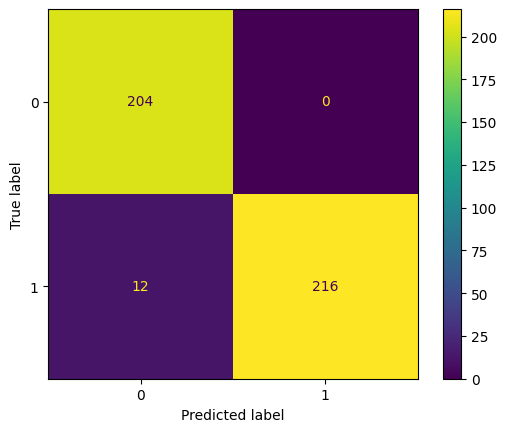

------------------------------------------------------------------------------------------------------


In [12]:
grid_search_model(LogisticRegression(),"logistic_regression")


# Naive bayes

GaussianNB

Model Used: gaussian_nbOn monk:  1
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean validation accuracy:  0.7333333333333334
Mean std validation accuracy:  0.12161871201057473
Model used: gaussian_nb, best parameters: {'var_smoothing': 0.02310129700083159}
accuracy on test set 0.748
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       216
           1       0.93      0.54      0.68       216

    accuracy                           0.75       432
   macro avg       0.80      0.75      0.74       432
weighted avg       0.80      0.75      0.74       432



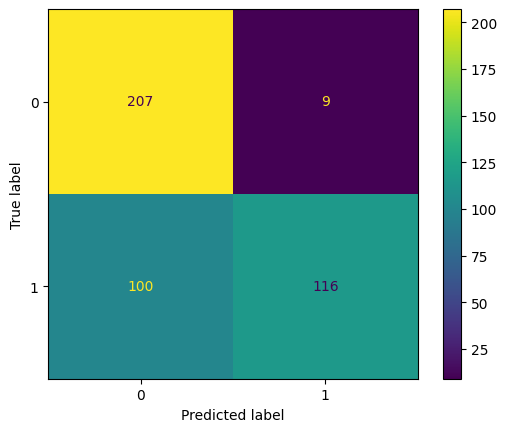

------------------------------------------------------------------------------------------------------
Model Used: gaussian_nbOn monk:  2
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean validation accuracy:  0.5859180035650623
Mean std validation accuracy:  0.06877106070495258
Model used: gaussian_nb, best parameters: {'var_smoothing': 1.0}
accuracy on test set 0.630
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       290
           1       0.32      0.11      0.17       142

    accuracy                           0.63       432
   macro avg       0.50      0.50      0.46       432
weighted avg       0.56      0.63      0.57       432



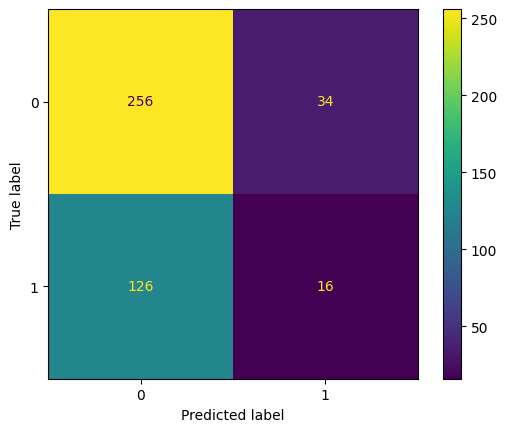

------------------------------------------------------------------------------------------------------
Model Used: gaussian_nbOn monk:  3
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean validation accuracy:  0.9339999999999999
Mean std validation accuracy:  0.03383949040856128
Model used: gaussian_nb, best parameters: {'var_smoothing': 0.533669923120631}
accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



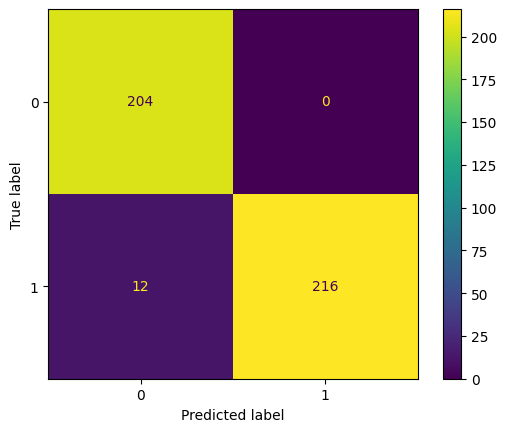

------------------------------------------------------------------------------------------------------


In [13]:
grid_search_model(GaussianNB(),"gaussian_nb")

BernoulliNB

Model Used: bernulli_nbOn monk:  1
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:1212: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Mean validation accuracy:  0.7333333333333334
Mean std validation accuracy:  0.12161871201057473
Model used: bernulli_nb, best parameters: {'alpha': 0.0, 'force_alpha': True}
accuracy on test set 0.750
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       216
           1       1.00      0.50      0.67       216

    accuracy                           0.75       432
   macro avg       0.83      0.75      0.73       432
weighted avg       0.83      0.75      0.73       432



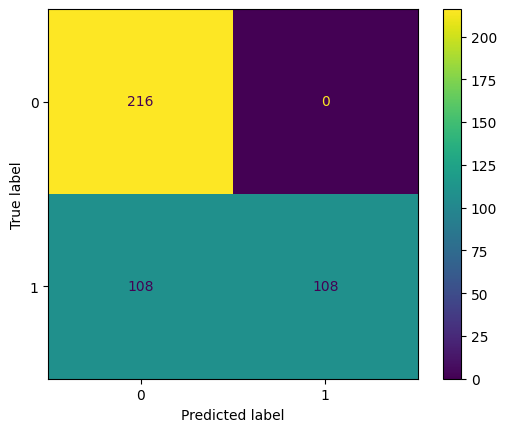

------------------------------------------------------------------------------------------------------
Model Used: bernulli_nbOn monk:  2
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean validation accuracy:  0.5267379679144385
Mean std validation accuracy:  0.08650879342777826
Model used: bernulli_nb, best parameters: {'alpha': 0.0, 'force_alpha': True}
accuracy on test set 0.606
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       290
           1       0.37      0.27      0.31       142

    accuracy                           0.61       432
   macro avg       0.53      0.52      0.52       432
weighted avg       0.58      0.61      0.59       432



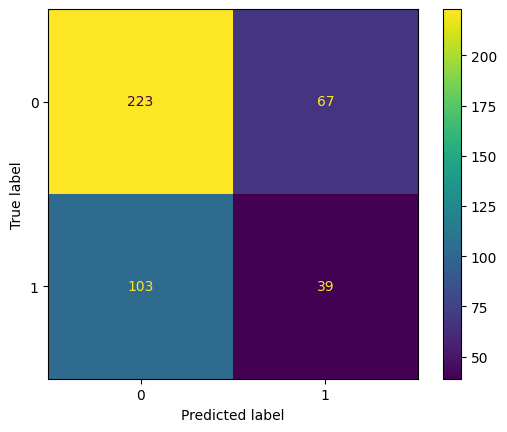

------------------------------------------------------------------------------------------------------
Model Used: bernulli_nbOn monk:  3
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean validation accuracy:  0.9259999999999999
Mean std validation accuracy:  0.03138647975022225
Model used: bernulli_nb, best parameters: {'alpha': 0.010101010101010102, 'force_alpha': True}
accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



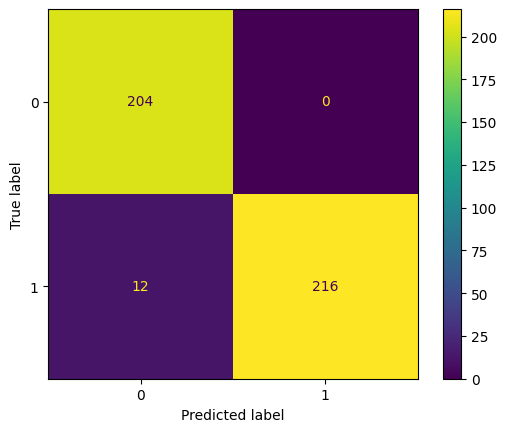

------------------------------------------------------------------------------------------------------


In [14]:
grid_search_model(BernoulliNB(),"bernulli_nb")

MultinomialNB

Model Used: multinomial_nbOn monk:  1
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mean validation accuracy:  0.7020000000000001
Mean std validation accuracy:  0.0988736567544662
Model used: multinomial_nb, best parameters: {}
accuracy on test set 0.713
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       216
           1       0.74      0.66      0.70       216

    accuracy                           0.71       432
   macro avg       0.72      0.71      0.71       432
weighted avg       0.72      0.71      0.71       432



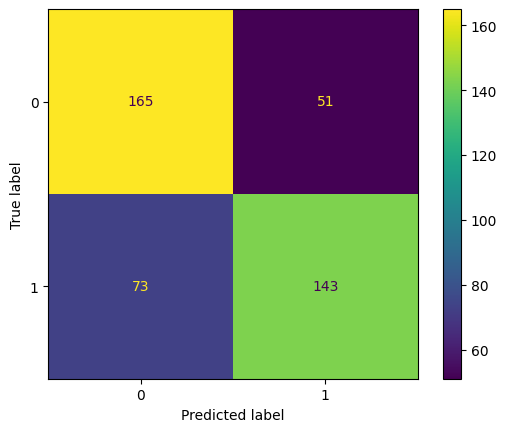

------------------------------------------------------------------------------------------------------
Model Used: multinomial_nbOn monk:  2
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mean validation accuracy:  0.5859180035650623
Mean std validation accuracy:  0.06877106070495258
Model used: multinomial_nb, best parameters: {}
accuracy on test set 0.616
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       290
           1       0.31      0.13      0.19       142

    accuracy                           0.62       432
   macro avg       0.49      0.49      0.47       432
weighted avg       0.55      0.62      0.56       432



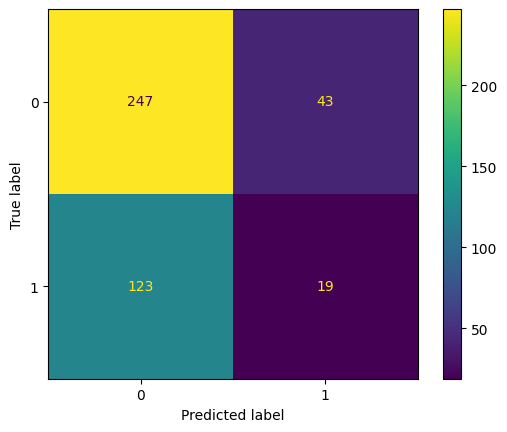

------------------------------------------------------------------------------------------------------
Model Used: multinomial_nbOn monk:  3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mean validation accuracy:  0.9259999999999999
Mean std validation accuracy:  0.03138647975022225
Model used: multinomial_nb, best parameters: {}
accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



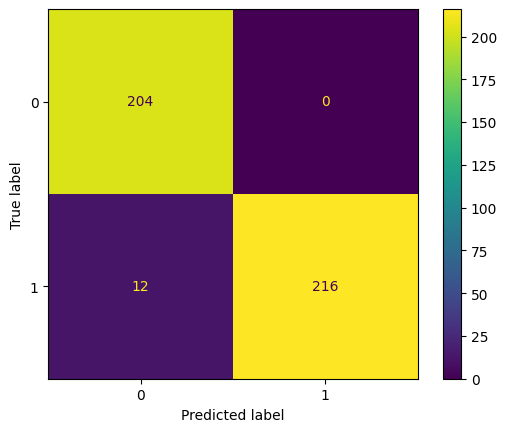

------------------------------------------------------------------------------------------------------


In [15]:
grid_search_model(MultinomialNB(),"multinomial_nb")

# K-NN

Model Used: knnOn monk:  1
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mean validation accuracy:  0.8306666666666667
Mean std validation accuracy:  0.029694743268426766
Model used: knn, best parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
accuracy on test set 0.880
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       216
           1       0.88      0.88      0.88       216

    accuracy                           0.88       432
   macro avg       0.88      0.88      0.88       432
weighted avg       0.88      0.88      0.88       432



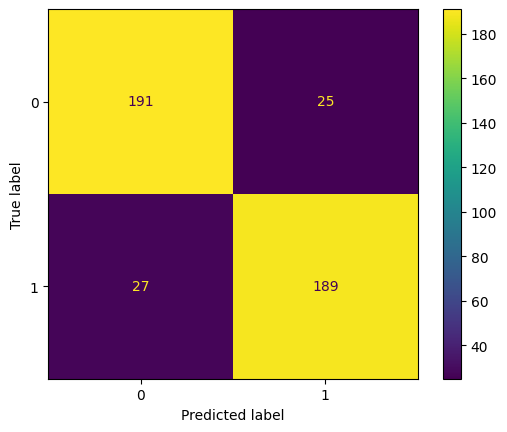

------------------------------------------------------------------------------------------------------
Model Used: knnOn monk:  2
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mean validation accuracy:  0.669162210338681
Mean std validation accuracy:  0.06615424523400157
Model used: knn, best parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 23, 'weights': 'uniform'}
accuracy on test set 0.650
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       290
           1       0.40      0.12      0.18       142

    accuracy                           0.65       432
   macro avg       0.54      0.52      0.48       432
weighted avg       0.59      0.65      0.58       432



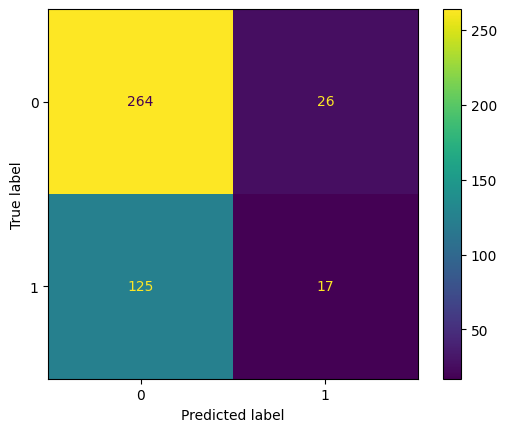

------------------------------------------------------------------------------------------------------
Model Used: knnOn monk:  3
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mean validation accuracy:  0.9183333333333333
Mean std validation accuracy:  0.03619392214170773
Model used: knn, best parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}
accuracy on test set 0.933
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       204
           1       0.96      0.91      0.93       228

    accuracy                           0.93       432
   macro avg       0.93      0.93      0.93       432
weighted avg       0.93      0.93      0.93       432



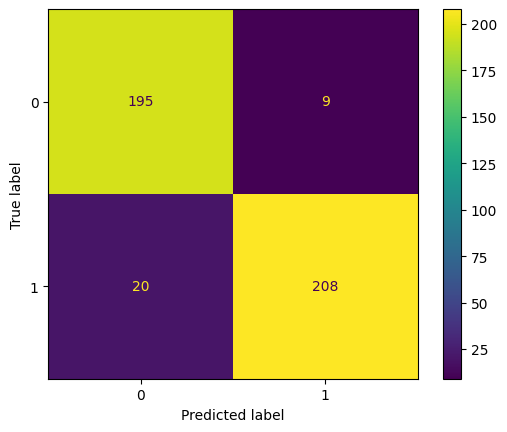

------------------------------------------------------------------------------------------------------


In [16]:
grid_search_model(KNeighborsClassifier(),"knn")

# SVM

Model Used: svmOn monk:  1
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean validation accuracy:  1.0
Mean std validation accuracy:  0.0
Model used: svm, best parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



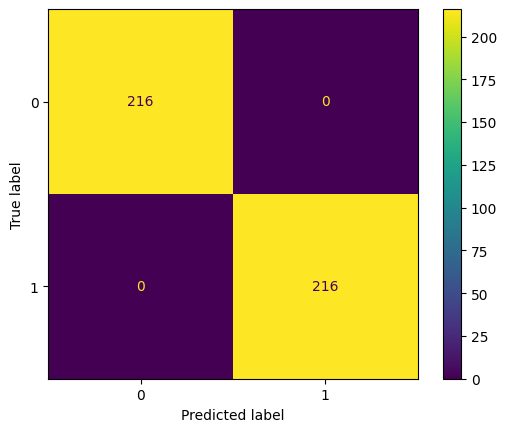

------------------------------------------------------------------------------------------------------
Model Used: svmOn monk:  2
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean validation accuracy:  0.9588235294117646
Mean std validation accuracy:  0.029994232432898744
Model used: svm, best parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



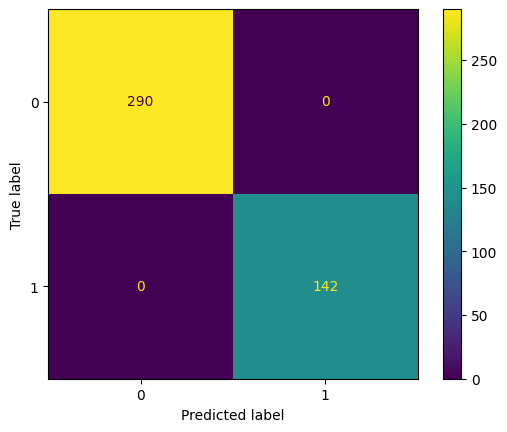

------------------------------------------------------------------------------------------------------
Model Used: svmOn monk:  3
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean validation accuracy:  0.9339999999999999
Mean std validation accuracy:  0.03383949040856128
Model used: svm, best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



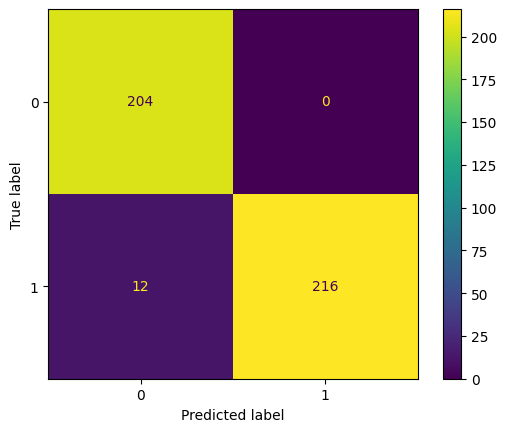

------------------------------------------------------------------------------------------------------


In [17]:
grid_search_model(SVC(),"svm")

# Decision tree

Model Used: decision_treeOn monk:  1
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mean validation accuracy:  0.9193333333333333
Mean std validation accuracy:  0.043838085927396256
Model used: decision_tree, best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy on test set 0.907
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       216
           1       0.86      0.97      0.91       216

    accuracy                           0.91       432
   macro avg       0.91      0.91      0.91       432
weighted avg       0.91      0.91      0.91       432



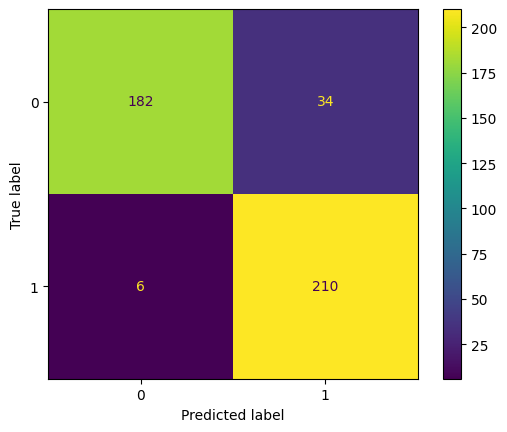

------------------------------------------------------------------------------------------------------
Model Used: decision_treeOn monk:  2
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mean validation accuracy:  0.6873440285204991
Mean std validation accuracy:  0.09800907006959503
Model used: decision_tree, best parameters: {'criterion': 'log_loss', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy on test set 0.870
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       290
           1       0.75      0.90      0.82       142

    accuracy                           0.87       432
   macro avg       0.85      0.88      0.86       432
weighted avg       0.88      0.87      0.87       432



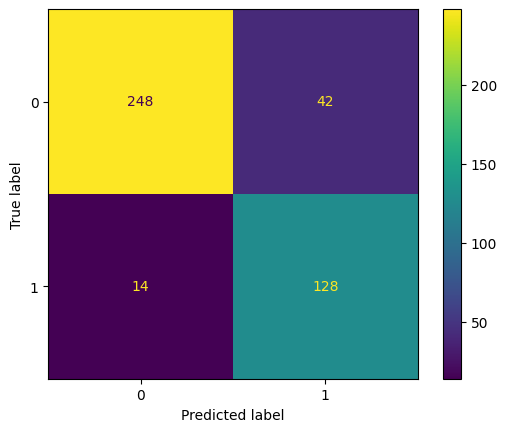

------------------------------------------------------------------------------------------------------
Model Used: decision_treeOn monk:  3
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mean validation accuracy:  0.9179999999999999
Mean std validation accuracy:  0.052211109928826445
Model used: decision_tree, best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8}
accuracy on test set 0.806
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       204
           1       0.93      0.68      0.79       228

    accuracy                           0.81       432
   macro avg       0.83      0.81      0.80       432
weighted avg       0.83      0.81      0.80       432



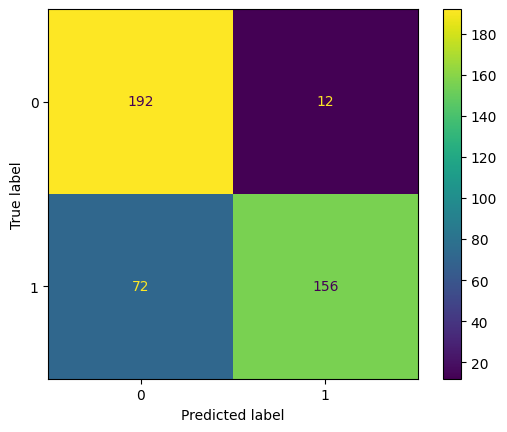

------------------------------------------------------------------------------------------------------


In [18]:
grid_search_model(DecisionTreeClassifier(),"decision_tree")

# Ensemble methods

Random Forest Classifier

Model Used: random_forestOn monk:  1
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mean validation accuracy:  0.984
Mean std validation accuracy:  0.03199999999999998
Model used: random_forest, best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 128}
accuracy on test set 0.995
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       216
           1       1.00      0.99      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



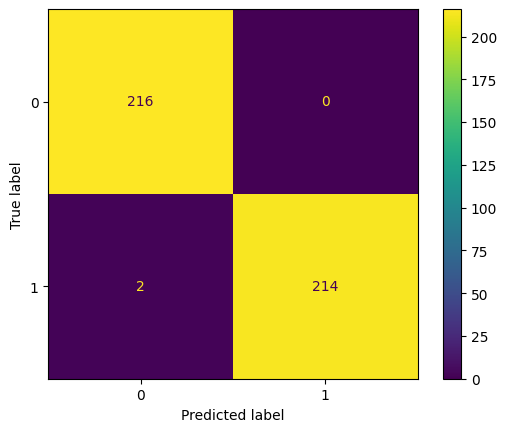

------------------------------------------------------------------------------------------------------
Model Used: random_forestOn monk:  2
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mean validation accuracy:  0.698752228163993
Mean std validation accuracy:  0.051748694999391796
Model used: random_forest, best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 32}
accuracy on test set 0.759
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       290
           1       0.63      0.66      0.64       142

    accuracy                           0.76       432
   macro avg       0.73      0.73      0.73       432
weighted avg       0.76      0.76      0.76       432



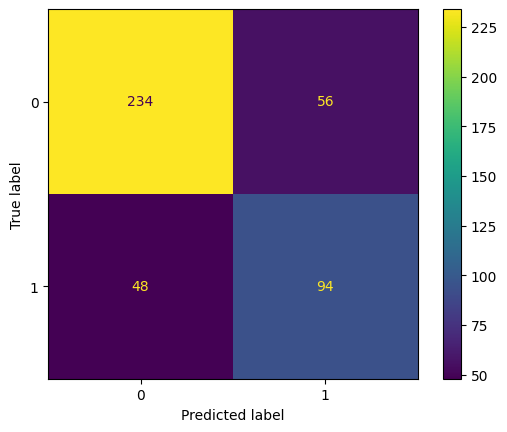

------------------------------------------------------------------------------------------------------
Model Used: random_forestOn monk:  3
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mean validation accuracy:  0.9423333333333334
Mean std validation accuracy:  0.033674916480965475
Model used: random_forest, best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 32}
accuracy on test set 0.975
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       204
           1       1.00      0.95      0.98       228

    accuracy                           0.97       432
   macro avg       0.97      0.98      0.97       432
weighted avg       0.98      0.97      0.97       432



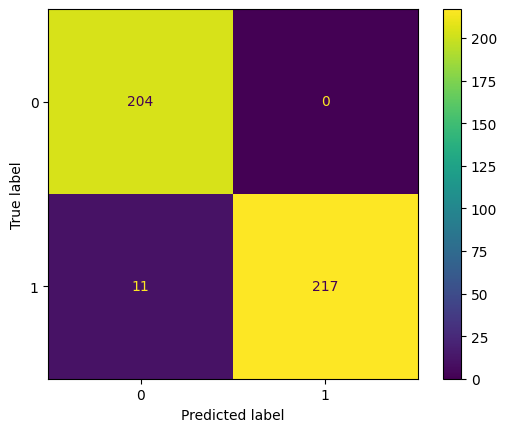

------------------------------------------------------------------------------------------------------


In [19]:
grid_search_model(RandomForestClassifier(),"random_forest")
